### Лабораторная работа №3. Исследование алгоритмов классификации

#### Постановка задачи
Выбрать атрибут, выступающий в роли целевого класса (метки)

Оценить сбалансированность классов;

Оценить и сравнить результаты классификации алгоритмами ***kNN***, ***Дерево решений***;

Сравнить результаты метриками оценки качества: ***Accuracy***, ***Precision***/***Recall***/***F1***, ***ROC***;

Объяснить полученные результаты, написать отчет с описанием выполнения каждой задачи.

In [46]:
import pandas as pd

# Plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing.
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Classifiers.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Metrics.
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)

In [47]:
df = pd.read_csv(r'raw/loan/loan_clean.csv')
df.sample(10)

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
4270,38,49821,500,0,0,16,16360,12,1,0,...,4151.750000,0.546448,7,148371,0.231360,0.245331,1551.218456,0.450706,0,51.0
12016,47,86653,569,0,3,28,9630,36,0,1,...,7221.083333,0.840328,6,7625,0.210130,0.251026,383.409676,0.190610,0,51.0
6928,39,25487,554,1,3,16,11119,60,0,1,...,2123.916667,0.740363,4,127560,0.239119,0.248385,325.305321,0.561842,0,53.0
4302,28,40509,535,0,1,4,41024,72,2,1,...,3375.750000,0.870326,6,9696,0.288524,0.265656,1144.806024,0.518050,0,52.0
3822,39,41626,506,0,3,19,24273,24,3,0,...,3468.833333,0.621246,6,7790,0.246273,0.238332,1281.320706,0.452694,0,56.0
16590,23,20022,574,0,0,1,24320,36,1,4,...,1668.500000,0.719401,4,161559,0.222320,0.201775,906.019848,0.721019,0,49.0
7575,23,192929,513,0,3,0,84996,72,1,1,...,10042.916667,0.713565,3,18490,0.343496,0.347685,2823.838895,0.301689,0,48.0
2590,54,90137,640,0,4,32,27595,48,0,2,...,7511.416667,0.699881,3,23830,0.202595,0.237780,896.263567,0.198666,0,49.0
3863,37,49189,552,0,2,14,43385,60,1,0,...,4099.083333,0.769746,6,226406,0.272385,0.313010,1438.518677,0.494139,0,52.0
6072,42,81801,616,0,0,18,15542,24,0,2,...,6816.750000,0.727864,9,18170,0.182542,0.190782,784.041328,0.156826,1,43.2


#### Выбор атрибута-метки
Набор данных является синтетическим примером данных, используемых для оценки кредитных рисков. Очевидно, что атрибут RiskScore является целевым для задач регрессии, а LoanApproved - меткой для классификации.

В первой работе категориальным признакам были присвоены числовые значения:
- EmploymentStatus: 'Employed': 0, 'Self-Employed': 1, 'Unemployed': 2
- EducationLevel: 'Master': 0, 'Associate': 1, 'Bachelor': 2, 'High School': 3, 'Doctorate': 4
- MaritalStatus: 'Married': 0, 'Single': 1, 'Divorced': 2, 'Widowed': 3
- HomeOwnershipStatus: 'Own': 0, 'Mortgage': 1, 'Rent': 2, 'Other': 3
- LoanPurpose: 'Home': 0, 'Debt Consolidation': 1, 'Education': 2, 'Other': 3, 'Auto': 4

Распределение классов для LoanApproved
0    15220
1     4780
Name: count, dtype: int64


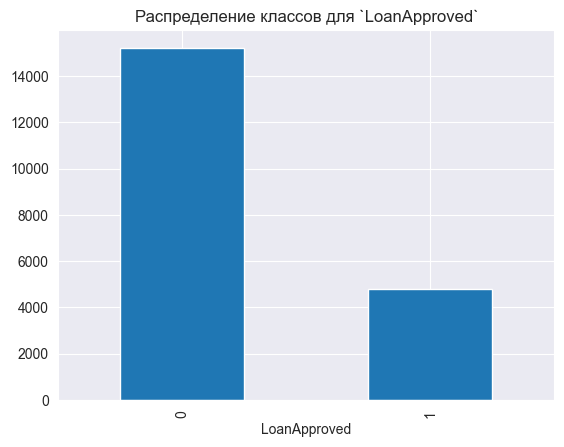

In [48]:
# Select target class.
target = 'LoanApproved'

# Check target class balance.
class_counts = df[target].value_counts()
print(f'Распределение классов для {class_counts}')
class_counts.plot(kind='bar', title=f'Распределение классов для `{target}`')
plt.show()

#### Балансировка
Видно, что одобренных кредитов меньше более чем в 3 раза.
Проверим два метода балансировки:
1. Under-sampling. Возьмём только 5000 примеров не одобренных кредитов. 
2. Over-sampling. С помощью imbalanced-learn.SMOTE увеличим количество одобренных кредитов в 3 раза.
Также возьмём изначальный набор, чтобы наглядно увидеть улучшение результатов классификации.

In [49]:
# Under sampling.
df_under_sampled = pd.concat([
    df[df[target] == 0].sample(n=5000, random_state=0),
    df[df[target] == 1]
])

In [50]:
# Over sampling.
smote = SMOTE(random_state=0)
x = df.drop(target, axis=1)
y = df[target]
x_smote, y_smote = smote.fit_resample(x, y)
df_over_sampled = pd.concat([pd.DataFrame(x_smote), pd.DataFrame(y_smote, columns=[target])], axis=1)

#### K Nearest Neighbors

In [51]:
def show_metrics(y_test, y_pred):
    """Display confusion matrix and metrics (accuracy, precision, recall, f1, roc)."""
    # Confusion matrix plot.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Compute metrics.
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc = round(roc_auc_score(y_test, y_pred), 3)
    
    # Show metrics as table.
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC'],
        'Score': [accuracy, precision, recall, f1, roc]
    })
    print(metrics_df.to_string(index=False))

In [52]:
def get_best_k(x_train, y_train, x_test, y_test, max_k) -> int:
    """Compare accuracy for different k-value with visualization."""
    # Get accuracy for different number of neighbors.
    scores_by_neighbors = []
    for k in range(1, max_k+1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        knn_pred = knn.predict(x_test)
        score = accuracy_score(y_test, knn_pred)
        scores_by_neighbors.append(score)
        
    # Plotting accuracy for different number of neighbors.
    plt.plot(
        range(1, max_k+1), scores_by_neighbors, 
        linestyle='dashed', marker='o'
    )
    plt.xticks(range(0, max_k+1, 2))
    plt.title("Accuracy vs k-value")
    plt.xlabel("k")
    plt.ylabel('Accuracy')
    plt.show()
    
    # Return best k-value.
    best_k = scores_by_neighbors.index(max(scores_by_neighbors)) + 1
    return best_k

In [53]:
def get_knn(x_train, y_train, x_test, y_test, k_max) -> KNeighborsClassifier:
    """Return KNN classifier with best k-value for given train and test sets."""
    k = get_best_k(x_train, y_train, x_test, y_test, k_max)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    knn_pred = knn.predict(x_test)
    
    print(f'KNN with k={k} results:')
    show_metrics(y_test, knn_pred)
    
    return knn

In [54]:
def df_to_knn(dataframe: pd.DataFrame, target_name: str, k_max: int) -> KNeighborsClassifier:
    """Split dataframe into train and test sets and return KNN classifier with best k-value."""
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop(target_name, axis=1), 
        dataframe[target_name],
        test_size=0.2,
        random_state=0
    )
    return get_knn(x_train, y_train, x_test, y_test, k_max)

KNN for not balanced DF (shape: (20000, 35))


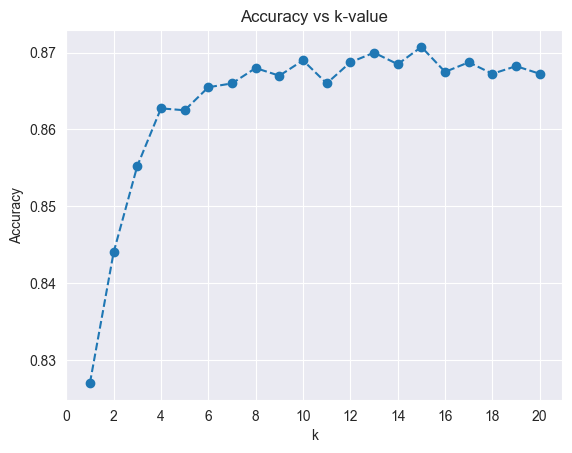

KNN with k=15 results:


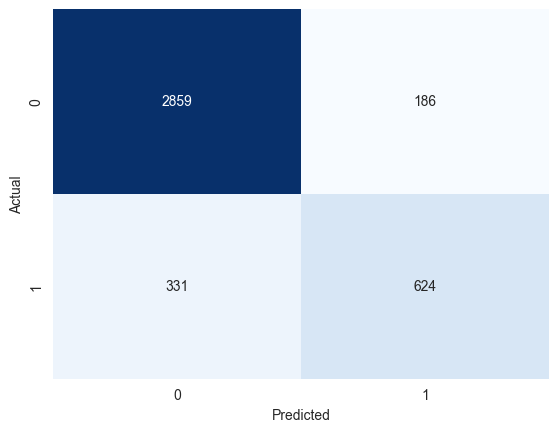

   Metric  Score
 Accuracy  0.871
Precision  0.770
   Recall  0.653
       F1  0.707
      ROC  0.796


KNN for under-sampled DF (shape: (9780, 35))


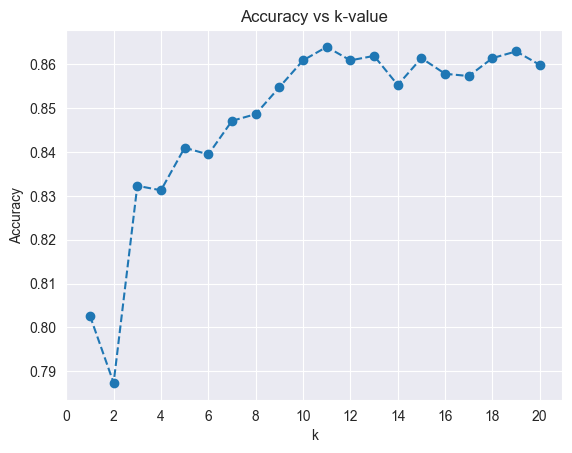

KNN with k=11 results:


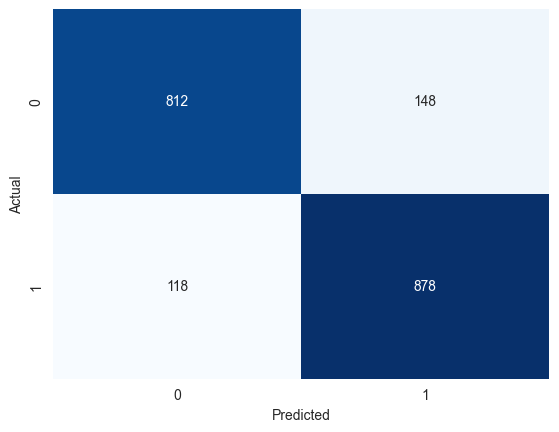

   Metric  Score
 Accuracy  0.864
Precision  0.856
   Recall  0.882
       F1  0.868
      ROC  0.864


KNN for over-sampled DF (shape: (30440, 35))


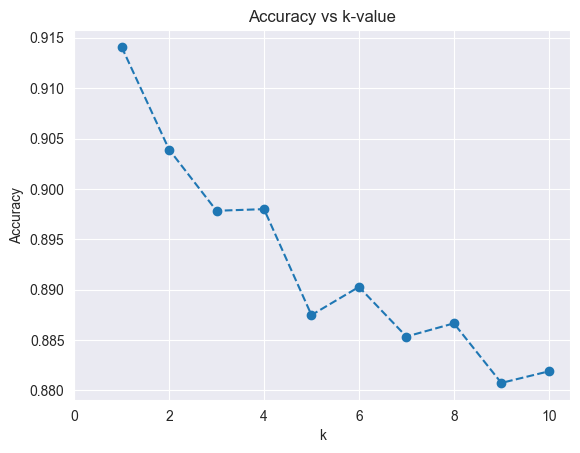

KNN with k=1 results:


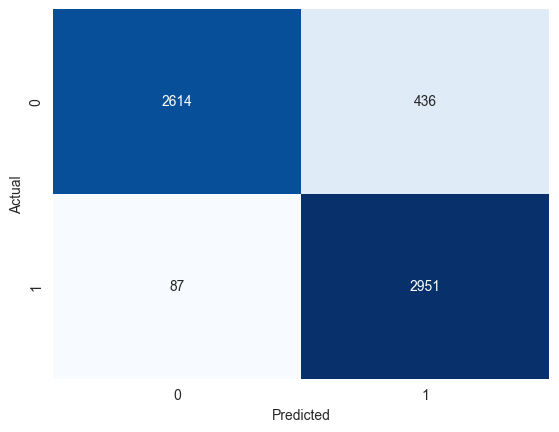

   Metric  Score
 Accuracy  0.914
Precision  0.871
   Recall  0.971
       F1  0.919
      ROC  0.914



In [55]:
print(f'KNN for not balanced DF (shape: {df.shape})')
df_to_knn(df, target, k_max=20)

print(f'\n\nKNN for under-sampled DF (shape: {df_under_sampled.shape})')
df_to_knn(df_under_sampled, target, k_max=20)

print(f'\n\nKNN for over-sampled DF (shape: {df_over_sampled.shape})')
df_to_knn(df_over_sampled, target, k_max=10)

print()

#### Decision Tree

In [56]:
def get_dt(x_train, y_train, x_test, y_test):
    """Return Decision Tree classifier for given train and test sets."""
    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    dt_pred = dt.predict(x_test)

    print(f'Decision Tree results:')
    show_metrics(y_test, dt_pred)

    return dt

In [57]:
def df_to_dt(dataframe: pd.DataFrame, target_name: str) -> DecisionTreeClassifier:
    """Split dataframe into train and test sets and return KNN classifier with best k-value."""
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop(target_name, axis=1), 
        dataframe[target_name],
        test_size=0.2,
        random_state=0
    )
    return get_dt(x_train, y_train, x_test, y_test)

DT for not balanced DF (shape: (20000, 35))
Decision Tree results:


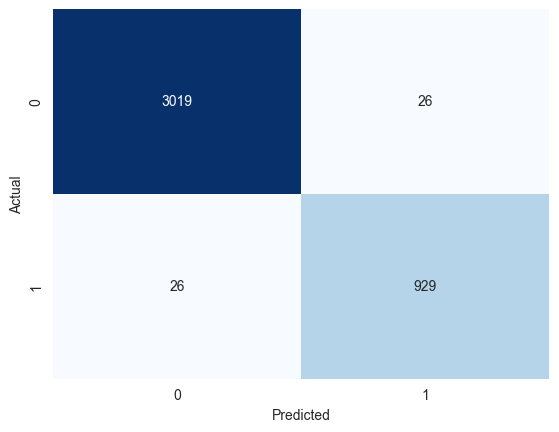

   Metric  Score
 Accuracy  0.987
Precision  0.973
   Recall  0.973
       F1  0.973
      ROC  0.982


DT for under-sampled DF (shape: (9780, 35))
Decision Tree results:


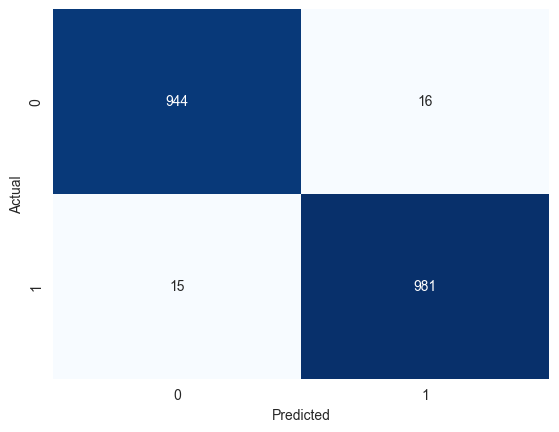

   Metric  Score
 Accuracy  0.984
Precision  0.984
   Recall  0.985
       F1  0.984
      ROC  0.984


DT for over-sampled DF (shape: (30440, 35))
Decision Tree results:


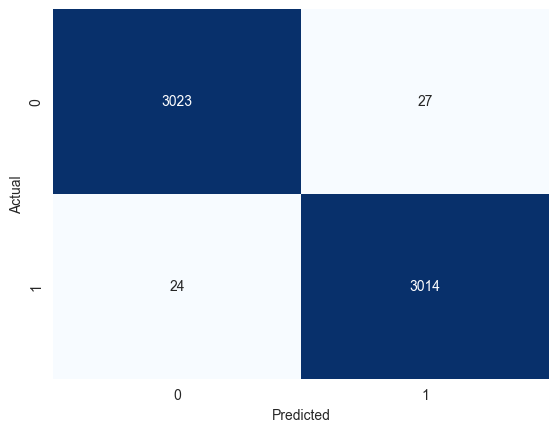

   Metric  Score
 Accuracy  0.992
Precision  0.991
   Recall  0.992
       F1  0.992
      ROC  0.992



In [58]:
print(f'DT for not balanced DF (shape: {df.shape})')
df_to_dt(df, target)

print(f'\n\nDT for under-sampled DF (shape: {df_under_sampled.shape})')
df_to_dt(df_under_sampled, target)

print(f'\n\nDT for over-sampled DF (shape: {df_over_sampled.shape})')
df_to_dt(df_over_sampled, target)

print()

#### Анализ результатов
Сокращения в таблице: 
- NB - not balanced
- US - under-sampled
- OS - over-sampled
- KNN - K Nearest Neighbors
- DT - Decision Tree

|           | NB KNN | US KNN | OS KNN | NB DT | US DT | OS DT |
|-----------|--------|--------|--------|-------|-------|-------|
| accuracy  | 0.871  | 0.864  | 0.914  | 0.987 | 0.984 | 0.992 |
| precision | 0.770  | 0.856  | 0.871  | 0.973 | 0.984 | 0.991 |
| recall    | 0.653  | 0.882  | 0.971  | 0.973 | 0.985 | 0.992 |
| f1        | 0.707  | 0.868  | 0.919  | 0.973 | 0.984 | 0.992 |
| roc       | 0.796  | 0.864  | 0.914  | 0.982 | 0.984 | 0.992 |

На основе полученных результатов можно сделать выводы:
- Для данного набора данных классификация деревом решений показывает лучший результат как по сравнению с KNN, так и в общем. Итог ожидаемый, ведь деревья решений хорошо справляются с бинарными метками и являются классическим примером для решения задач одобрения кредитов.
- Результаты accuracy для несбалансированных данных хорошо отражают причину недостаточности этой метрики. Для NB KNN accuracy = 0.871, хотя более точные метрики показывают результат на 10-20% ниже. Это подчеркивает важность использования разных метрик для качественного анализа результатов модели.
- Over-sampling методом SMOTE показало наилучшие результаты, ведь изначальный объем данных не слишком велик.
- Для KNN и DT, как для зависимых от балансировки методов, любая балансировка, даже простой under-sampling, улучшает результаты. 
